# 0 Preparación del entorno.

## 0.1 Definición de parámetros

In [1]:
tfm_path='TFM data/'
H1_code = 'OMNI2_H0_MRG1HR'
M5_code = 'OMNI_HRO2_5MIN'
lookback = 12
lookforward = 4
tfm_path_Nh_models = f'PRED_{lookforward}h/'
cols_to_use = ['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'E_field', 'plasma_T', 'plasma_V', 'Dst'] # 'AP', out
col_to_predict = "Dst"
hstorms_data = 'historical_storms_gruet2018.csv'
weak_threshold = -30 #1
moderate_threshold = -50 #2
strong_threshold = -100 #3
severe_threshold = -200 #4
great_threshold = -300 #5
gamma_value=0.0001
temporal_margin=5*24 # margen para obtener tiempos ampliados de las tormentas de gruet et al 2018
test_size = 0.2
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

## 0.2 Montar Google Drive (obtención de datos)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# !rm -rf sample_data/

## 0.3 Importación de librerías

In [3]:
# !pip install optuna

In [4]:
import os

import numpy as np

# librerías de manipulación de datos y gráficos
import pandas as pd
import matplotlib.dates as mdates
import numpy as np

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# modelo
from sklearn.svm import SVR
#from thundersvm import SVR
# escalado y división en train/test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# obtención de métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.metrics import explained_variance_score, max_error

# meta
# timer
import time

#optuna
import optuna
import optuna_dashboard
from sklearn.model_selection import cross_val_score

## 0.4 Definición de funciones

In [5]:

def exploracion_inicial_datos(df):
    """
    Función para realizar una exploración inicial de los datos.

    Parámetros:
    df (dataframe): El dataframe que contiene los datos.

    Muestra las primeras filas, estadísticas descriptivas, valores faltantes,
    histogramas de variables numéricas y un mapa de calor de la correlación.
    """
    # Configuración de visualización
    sns.set(style="whitegrid")  # Estilo de gráficos


    print("Primeras filas del DataFrame:")
    print(df.head())


    print("\nDescripción estadística de los datos:")
    print(df.describe())


    print("\nValores faltantes por columna:")
    print(df.isnull().sum())


    print("\nVisualización de histogramas para variables numéricas:")
    df.hist(bins=15, figsize=(15, 10), layout=(5, 4))
    plt.show()
    print("\nMapa de calor de la matriz de correlación:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()


def calcular_layout_optimo(num_cols):
    """
    Calcula el número óptimo de filas y columnas para una figura con subgráficos,
    tratando de mantener una forma que sea visualmente agradable y que aproveche el espacio.

    Parámetros:
    num_cols (int): Número total de columnas (gráficos) a mostrar.

    Retorna:
    (int, int): Número de filas y columnas para el layout de los subgráficos.
    """
    # Calcula el número óptimo de columnas teniendo un límite visual razonable
    cols_per_row = int(np.sqrt(num_cols)) + 1  # Ajuste para maximizar el uso del espacio y la forma de la figura
    rows_needed = (num_cols + cols_per_row - 1) // cols_per_row  # Redondeo hacia arriba para incluir todas las columnas
    return rows_needed, cols_per_row

def exploracion_histogramas(df):
    """
    Función para generar histogramas para todas las columnas numéricas en un DataFrame,
    excluyendo las columnas de tipo datetime y no numéricas.

    Parámetros:
    df (DataFrame): DataFrame de pandas con los datos a analizar.
    """
    # Eliminar columnas no numéricas y de tipo datetime
    df_numerico = df.select_dtypes(include=[np.number])

    # Número de columnas numéricas
    num_cols = df_numerico.shape[1]

    # Verificar si hay columnas para mostrar
    if num_cols == 0:
        print("No hay columnas numéricas para mostrar.")
        return

    # Calculando el layout necesario
    rows_needed, cols_per_row = calcular_layout_optimo(num_cols)

    # Crear histogramas
    df_numerico.hist(bins=15, figsize=(15, 10), layout=(rows_needed, cols_per_row))
    plt.show()

def imputar_nan(df):
  df.interpolate(method='linear', inplace=True)
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  if sum(df.isnull().sum())!=0:
    print("Faltan nulos por tratar")
  return df

def visualizar_nulos_plot(df, variable_with_nans):
    """
    Plot the specified 'variable_with_nans' column and 'Dst' column from the DataFrame.

    Parameters:
    - df: pandas.DataFrame containing the data to plot.
    - variable_with_nans: str, the name of the column in the DataFrame to plot, which may contain NaNs.

    The function assumes that 'Dst' is a column name in the DataFrame and that the DataFrame's index is suitable for plotting (e.g., datetime).
    """
    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 8))

    # Handling NaNs in the 'variable_with_nans' column before plotting
    df_plot = df.copy()
    df_plot[variable_with_nans] = df_plot[variable_with_nans].fillna(method='ffill')  # Forward fill to handle NaNs

    # Plotting 'variable_with_nans' on the first subplot
    ax1.scatter(df_plot.index, df_plot[variable_with_nans], label=variable_with_nans, color='blue')
    ax1.set_ylabel(variable_with_nans)
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plotting 'Dst' on the second subplot
    ax2.plot(df_plot.index, df_plot['Dst'], label='Dst', color='red')
    ax2.set_ylabel('Dst')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    # Setting the x-axis label only on the bottom subplot
    ax2.set_xlabel('Datetime')

    # Improve layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example of how to use this function with a DataFrame containing NaNs
data = {
    'Datetime': pd.date_range(start='2021-01-01', periods=100, freq='D'),
    'variable_with_nans': pd.Series(range(100)).where(lambda x : x % 10 != 0),
    'Dst': range(100, 0, -1)
}
df = pd.DataFrame(data)
df.set_index('Datetime', inplace=True)

def create_window_df_svr(list_dfs, lookback, lookforward, cols_to_use, col_to_predict, scaler_label=None):
    """
    Creates input and output datasets for SVR training from a list of DataFrames, incorporating windowing and optional descaling for target

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to process.
    lookback (int): Number of past records to include as features for each prediction.
    lookforward (int): Number of records ahead to predict.
    cols_to_use (list of str): List of column names to use as features.
    col_to_predict (str): Column name to predict.
    scaler_label (StandardScaler, optional): Scaler for the output variable, used for inverse transformation.

    Returns:
    tuple: A tuple containing arrays for training features and labels.
    """
    x_train, y_train = [], []

    for df_ in list_dfs:
        df = df_.copy()

        for i in range(len(df) - lookback - lookforward + 1):
            x_train.append(np.asarray(df.iloc[i:i+lookback][cols_to_use].values))
            y_train.append(np.asarray(df.iloc[i+lookback][col_to_predict]))

    if scaler_label is not None:
        y_train = scaler_label.inverse_transform(np.asarray(y_train).reshape(-1,1))

    return np.asarray(x_train), np.asarray(y_train)


def filter_storms(df, historical_storms, temporal_margin):
    """
    Filter DataFrame entries based on the occurrence of storms within specific time intervals.

    Parameters:
    df (pandas.DataFrame): DataFrame containing time-series data with a 'Datetime' column.
    historical_storms (pandas.DataFrame): DataFrame containing the start and end times of historical storms.
    temporal_margin (int): Number of rows before and after the minimum Dst index to include in the result.

    Returns:
    list: A list of DataFrame snippets corresponding to the specified storm intervals.
    """
    all_storms = []
    for i in range(len(historical_storms)):
        df_tmp = df[(df["Datetime"] >= historical_storms.iloc[i]["start"]) & (df["Datetime"] <= historical_storms.iloc[i]["end"])]
        idx = df_tmp['Dst'].idxmin()
        all_storms.append(df.iloc[idx-temporal_margin:idx+temporal_margin])
    return all_storms

def combinar_dataframes_solapados(dfs):
    """
    Combines overlapping DataFrames in a list into non-overlapping DataFrames based on the 'Datetime' column.

    Parameters:
    dfs (list of pandas.DataFrame): List of DataFrames to combine.

    Returns:
    list: A list of combined DataFrames without overlap.
    """
    dfs.sort(key=lambda x: x['Datetime'].min())
    combinados = []
    combinacion_actual = dfs[0]

    for df in dfs[1:]:
        if df['Datetime'].min() <= combinacion_actual['Datetime'].max():
            combinacion_actual = pd.concat([combinacion_actual, df]).drop_duplicates().sort_values(by='Datetime')
        else:
            combinados.append(combinacion_actual)
            combinacion_actual = df
    combinados.append(combinacion_actual)
    return combinados

def scale_data(list_dfs, cols_to_use, col_to_predict):
    """
    Scales columns in a list of DataFrames using StandardScaler.

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to scale.
    cols_to_use (list of str): Column names to apply scaling to.
    col_to_predict (str): Column name used as a label for prediction.

    Returns:
    tuple: A tuple containing the list of scaled DataFrames and the label scaler.
    """
    list_dfs_ = []
    scaler_cols = StandardScaler()
    scaler_label = StandardScaler()
    scaler_cols.fit(pd.concat(list_dfs)[cols_to_use])
    scaler_label.fit(np.asarray(pd.concat(list_dfs)[col_to_predict]).reshape(-1,1))

    for df_ in list_dfs:
        df = df_.copy()
        df[cols_to_use] = scaler_cols.transform(df[cols_to_use])
        list_dfs_.append(df)

    return list_dfs_, scaler_label



def calc_metrics(predictions, y_test):
  # Mean Squared Error
  mse = mean_squared_error(y_test, predictions)
  # Mean Absolute Error
  mae = mean_absolute_error(y_test, predictions)
  # R^2 Score, the coefficient of determination
  r2 = r2_score(y_test, predictions)
  # Median Absolute Error
  medae = median_absolute_error(y_test, predictions)
  # Explained Variance Score
  explained_variance = explained_variance_score(y_test, predictions)
  # Max Error
  max_err = max_error(y_test, predictions)

  return mse, mae, r2, medae, explained_variance, max_err


def formatear_tiempo(segundos):
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segundos = segundos % 60
    return f"{horas} horas, {minutos} minutos, {segundos:.2f} segundos"


In [6]:
def evaluate_svr_models(X_train, y_train, X_test, y_test, kernels, C_values, epsilon_values, gamma_values, degree_values, verbose=True):
    """
    Evaluate SVR models with different hyperparameter configurations and kernel types.

    Args:
    X_train (array): Independent training data.
    y_train (array): Dependent training data (target).
    X_test (array): Independent test data.
    y_test (array): Dependent test data (target).
    kernels (list): List of kernel types to evaluate.
    C_values (list): List of values for the penalty parameter C.
    epsilon_values (list): List of values for the epsilon parameter.
    gamma_values (list): List of values for the gamma parameter.
    degree_values (list): List of values for the degree parameter (used only in polynomial kernels).
    verbose (bool, optional): If True, prints messages during the evaluation process. Default is True.

    Returns:
    DataFrame: A pandas DataFrame containing evaluation metrics for each parameter configuration.
    dict: A dictionary of trained models, with keys describing the specific parameter configuration.

    Note:
    Assumes that the 'precomputed' kernel is only used if the 'precomputed_matrix' is defined in the local environment.
    """
    results = []
    models_dict = {}

    for kernel_ in kernels:
        for C in C_values:
            for epsilon in epsilon_values:
                # Check parameter relevance for gamma and degree for the current kernel
                relevant_gamma_values = gamma_values if kernel_ in ['rbf', 'sigmoid', 'poly'] else [None]
                relevant_degree_values = degree_values if kernel_ == 'poly' else [None]

                for gamma in relevant_gamma_values:
                    for degree in relevant_degree_values:
                        start = time.time()
                        config_key = f"{kernel_}_C{C}_eps{epsilon}_gamma{gamma}_deg{degree}"
                        if verbose:
                            print(f"Starting {config_key}")

                        if kernel_ == "precomputed":
                            if 'precomputed_matrix' in locals():
                                model = SVR(kernel='precomputed', C=C, epsilon=epsilon)
                                model.fit(precomputed_matrix, y_train)
                                models_dict[config_key] = model
                                continue
                            else:
                                if verbose:
                                    print("Precomputed matrix not defined for kernel='precomputed'")
                                continue

                        model = SVR(kernel=kernel_, C=C, epsilon=epsilon, gamma=(gamma if gamma is not None else 0.01), degree=(degree if degree is not None else 3))
                        model.fit(X_train, y_train)
                        models_dict[config_key] = model

                        predictions = model.predict(X_test)
                        mse, mae, r2, medae, explained_variance, max_err = calc_metrics(predictions, y_test)
                        end = time.time()
                        time_exec = formatear_tiempo(end - start)

                        results.append({
                            "kernel": kernel_,
                            "C": C,
                            "epsilon": epsilon,
                            "gamma": gamma,
                            "degree": degree,
                            "mse": mse,
                            "mae": mae,
                            "r2": r2,
                            "medae": medae,
                            "exp_var": explained_variance,
                            "max_err": max_err,
                            "time_exec": time_exec
                        })

                        print(f"{config_key} finished. Time for iteration: {time_exec} | mae: {mae} | mse: {mse} | exp_var: {explained_variance} | max_err: {max_err}")

    df_results = pd.DataFrame(results)
    return df_results, models_dict


# 1. Carga y preparación de datos

## 1.1 Carga de los datos

In [7]:
hd = pd.read_csv(tfm_path+H1_code+'.csv', parse_dates=["Datetime"])
# md = pd.read_csv(tfm_path+M5_code+'.csv', parse_dates=["Datetime"]) # no se va a usar por ahora
historical_storms = pd.read_csv(tfm_path+hstorms_data)
# historical_storms = historical_storms.drop(columns=['Min. Dst (nT)','Unnamed: 0'], axis=1)

- Ver qué columnas y tipo de datos contienen los df.

In [8]:
hd.columns

Index(['ID_IMF', 'ID_plasma', 'Bmag', 'dev_Bmag', 'Bx', 'By_gse', 'Bz_gse',
       'By_gsm', 'Bz_gsm', 'dev_Bx', 'dev_By', 'dev_Bz', 'P_density',
       'dev_P_density', 'AP', 'dev_AP', 'E_field', 'plasma_T', 'dev_plasma_T',
       'plasma_V', 'Dst', 'Datetime'],
      dtype='object')

In [9]:
hd.dtypes

ID_IMF                  float64
ID_plasma               float64
Bmag                    float64
dev_Bmag                float64
Bx                      float64
By_gse                  float64
Bz_gse                  float64
By_gsm                  float64
Bz_gsm                  float64
dev_Bx                  float64
dev_By                  float64
dev_Bz                  float64
P_density               float64
dev_P_density           float64
AP                      float64
dev_AP                  float64
E_field                 float64
plasma_T                float64
dev_plasma_T            float64
plasma_V                float64
Dst                     float64
Datetime         datetime64[ns]
dtype: object

In [10]:
historical_storms.columns

Index(['Unnamed: 0', 'Min. Dst (nT)', 'start', 'end', 'storm'], dtype='object')

In [11]:
historical_storms.dtypes

Unnamed: 0        int64
Min. Dst (nT)     int64
start            object
end              object
storm             int64
dtype: object

- Ordenar las tormentas en caso de que no lo estén
- Convertir todas las fechas a datetime de pd.

In [12]:
# Ordenar los dataframes por fecha
historical_storms = historical_storms.sort_values(by='start')

# convertir las columnas de tiempo a datetime64
hd['Datetime']=pd.to_datetime(hd['Datetime'])
historical_storms['start']=pd.to_datetime(historical_storms['start'])
historical_storms['end']=pd.to_datetime(historical_storms['end'])

# Cuando se utilizan los datos a 5 minutos, se unen a 5min
#data = pd.merge(md, hd[["Datetime", "Dst"]], on='Datetime', how='left')

## 1.2 Exploración inicial de los datos

- head del df

In [13]:
# hd.head()

- descripción estadística de los datos

In [14]:
# hd.describe()

- ver los valores nulos

In [15]:
# hd.isnull().sum()

In [16]:
# hd.isnull().sum() / len(hd) * 100

- Histograma para variables numéricas (todas, en este caso, pero hemos quitado datetime porque no es muy util al ser una serie temporal).

In [17]:
# exploracion_histogramas(hd)

- Visualizaciónd e historical_storms

In [18]:
# storms_data = historical_storms.copy()

In [19]:
# # Convertir las columnas de fecha y hora a datetime
# storms_data['start'] = pd.to_datetime(storms_data['start'])
# storms_data['end'] = pd.to_datetime(storms_data['end'])
# # Calcular la duración de cada tormenta en horas
# storms_data['duration_hours'] = (storms_data['end'] - storms_data['start']).dt.total_seconds() / 3600

# # Gráfico de la distribución de las intensidades mínimas de las tormentas
# plt.figure(figsize=(8, 4))
# sns.histplot(storms_data['Min. Dst (nT)'], bins=30, kde=True, color='blue')
# plt.title('Distribución de Intensidades Mínimas de Tormentas Geomagnéticas')
# plt.xlabel('Min. Dst (nT)')
# plt.ylabel('Frecuencia')
# plt.grid(True)
# plt.show()

Gráfico de dispersión entre la duración y la intensidad mínima

In [20]:
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='duration_hours', y='Min. Dst (nT)', data=storms_data)
# plt.title('Correlación entre Duración e Intensidad Mínima de Tormentas')
# plt.xlabel('Duración (Horas)')
# plt.ylabel('Min. Dst (nT)')
# plt.grid(True)
# plt.show()

- Ver el timeline de las tormentas

In [21]:
# import plotly.graph_objects as go

# # Crear la figura
# fig = go.Figure()

# # Añadir cada tormenta como un segmento de línea en el gráfico
# for i, row in storms_data.iterrows():
#     fig.add_trace(go.Scatter(
#         x=[row['start'], row['end']],
#         y=[i, i],
#         mode='lines+markers',
#         name=f"Tormenta {row['storm']}"
#     ))

# # Ajustar la presentación de la figura
# fig.update_layout(
#     title="Línea de Tiempo de Tormentas Históricas",
#     xaxis_title="Fecha",
#     yaxis_title="Tormenta",
#     yaxis=dict(
#         tickmode='array',
#         tickvals=list(range(len(storms_data)))
#     ),
#     showlegend=False,
#     xaxis=dict(
#         rangeslider=dict(
#             visible=True
#         ),
#         type="date"
#     )
# )

# # Mostrar la figura
# fig.show()

Mapa de calor de la matriz de correlación

In [22]:
# plt.figure(figsize=(15, 8))
# sns.heatmap(hd.corr(), annot=True, fmt=".2f", cmap='coolwarm')
# plt.show()

## 1.3 Limpieza y procesamiento de los datos

### 1.3.1 Tratamiento de valores faltantes

In [23]:
sum(hd.isnull().sum())

42472

In [24]:
hd = imputar_nan(hd)

/tmp/ipykernel_18501/2672241348.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_18501/2672241348.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [25]:
sum(hd.isnull().sum())

0

### 1.3.2 Normalización de los datos

In [26]:
all_storms = filter_storms(hd, historical_storms, temporal_margin)
all_storms = combinar_dataframes_solapados(all_storms)

In [27]:
pd.concat(all_storms).to_csv(tfm_path+"all_storms.csv")

In [28]:
storms_check = pd.concat(all_storms)

In [29]:
all_storms, scaler_target = scale_data(all_storms, cols_to_use, col_to_predict)

### 1.3.3 Codificación de variables categóricas

* No existe codificación de variables categóricas porque **no hay variables categóricas). A continuación, se muestra.

In [30]:
pd.concat(all_storms).dtypes

ID_IMF                  float64
ID_plasma               float64
Bmag                    float64
dev_Bmag                float64
Bx                      float64
By_gse                  float64
Bz_gse                  float64
By_gsm                  float64
Bz_gsm                  float64
dev_Bx                  float64
dev_By                  float64
dev_Bz                  float64
P_density               float64
dev_P_density           float64
AP                      float64
dev_AP                  float64
E_field                 float64
plasma_T                float64
dev_plasma_T            float64
plasma_V                float64
Dst                     float64
Datetime         datetime64[ns]
dtype: object

# 3 Entrenamiento de modelos

## 3.1 Creación de la ventana temporal

In [31]:
# x_window, y_window = create_window_df_svr(all_storms, lookforward, cols_to_use, col_to_predict, scaler_target) # desescalado
x_window, y_window = create_window_df_svr(all_storms, lookback, lookforward, cols_to_use, col_to_predict) # sin desescalar

## 3.2 División en train-test.

In [32]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(x_window, y_window, test_size=test_size, random_state=42)

X_train = X_train.reshape(X_train.shape[0], -1)  # Transforma a (n_samples, n_features*lookback)
X_test = X_test.reshape(X_test.shape[0], -1)  # Lo mismo para el conjunto de prueba
#X_train = np.squeeze(X_train, axis=1)
#X_test = np.squeeze(X_test, axis=1)

## 4 Optimización de la selección de hiperparámetros

### Random

In [33]:
# def objective(trial):
#     # Suggesting hyperparameters using suggest_float
#     C = trial.suggest_float('C', 1e-6, 1e2, log=True)  # Logarithmic for C
#     gamma = trial.suggest_float('gamma', 1e-6, 1e2, log=True)  # Logarithmic for gamma
#     epsilon = trial.suggest_float('epsilon', 0.001, 0.1)  # Linear for epsilon
#     degree = trial.suggest_int('degree', 1, 10)  # Linear for epsilon
#     kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])

#     # Create and train the SVR model from Thunder SVM
#     model = SVR(C=C, gamma=gamma, epsilon=epsilon, degree=degree, kernel=kernel)

#     # Evaluate the model using cross-validation
#     score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
#     return -score

In [34]:
# # Define the full path to the SQLite database
# database_path = os.path.join(tfm_path+tfm_path_Nh_models, 'random_20240712-kaisa-non-linear_study.db')
# storage_url = f'sqlite:///{database_path}'
# new_study_name="random_kaisa-non-linear-study-20240712"

In [35]:
# # Create the study with the GridSampler
# study = optuna.create_study(study_name=new_study_name,storage=storage_url, load_if_exists=True,sampler=optuna.samplers.RandomSampler())

In [36]:
# # Ejecutar la optimización
# study.optimize(objective, n_trials=100, timeout=600, gc_after_trial=True)

### Linear

In [37]:
# # Define the full path to the SQLite database
# database_path = os.path.join(tfm_path+tfm_path_Nh_models, 'GRID_20240712-kaisa-linear_study.db')
# storage_url = f'sqlite:///{database_path}'
# new_study_name="GRID_kaisa-linear-study-20240712"

In [38]:
# def objective(trial):
#     C = trial.suggest_float('C', 1e-6, 1e2, log=True)
#     gamma = trial.suggest_float('gamma', 1e-6, 1e2, log=True)
#     epsilon = trial.suggest_float('epsilon', 0.001, 0.1)
#     degree = trial.suggest_int('degree', 1, 10)
#     kernel = trial.suggest_categorical('kernel', ['linear'])

#     # Create and train the model, evaluate using cross-validation
#     model = SVR(C=C, gamma=gamma, epsilon=epsilon, degree=degree, kernel=kernel)
#     score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
#     return -score

# # Define the parameter grid
# param_grid = {
#     'C': np.logspace(-6, 2, num=6),  # Fewer points for demonstration
#     'gamma': [1], # not used in linear
#     'epsilon': np.linspace(0.001, 0.1, num=6),
#     'degree': [1],  # Fixed for simplification, not used in linear
#     'kernel': ['linear']  # Fixed to 'linear'
# }

In [39]:
# # Create the study with the GridSampler
# study = optuna.create_study(study_name=new_study_name,storage=storage_url, load_if_exists=True,sampler=optuna.samplers.GridSampler(param_grid))

In [40]:
# study.optimize(objective, timeout=600, n_trials=len(param_grid['C']) * len(param_grid['gamma']) * len(param_grid['epsilon']))

### Grid for different kernels

In [41]:
# Define the full path to the SQLite database
database_path = os.path.join(tfm_path+tfm_path_Nh_models, f'DEF_kaisa_grid_allKernels_pred{lookforward}H_20240713.db')
storage_url = f'sqlite:///{database_path}'
new_study_name=f"DEF_kaisa_grid_allKernels_pred{lookforward}_20240713"

In [42]:
param_grid = {
    'C': np.logspace(-6, 2, num=6).tolist(),
    'gamma': np.logspace(-6, 2, num=6).tolist(),
    'epsilon': np.linspace(0.001, 0.1, num=6).tolist(),
    'degree': list(range(1, 11)),
    'kernel': ['linear', 'poly', 'rbf']
}

def objective(trial):
    C = trial.suggest_float('C', 1e-6, 1e2, log=True)
    epsilon = trial.suggest_float('epsilon', 0.001, 0.1)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])

    if kernel == 'linear':
        gamma = 1
        degree = 1
    elif kernel == 'poly':
        gamma = 1
        degree = trial.suggest_int('degree', 1, 10)
    elif kernel == 'rbf':
        gamma = trial.suggest_float('gamma', 1e-6, 1e2, log=True)
        degree = 1

    model = SVR(C=C, gamma=gamma, epsilon=epsilon, degree=degree, kernel=kernel, max_iter=100000000)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return -score

def print_metrics(study, trial):
    print(f'Trial {trial.number}: Value={trial.value}, Params={trial.params}')

In [43]:
study = optuna.create_study(study_name=new_study_name, storage=storage_url, load_if_exists=True, sampler=optuna.samplers.GridSampler(param_grid))

[I 2024-07-14 16:59:18,400] Using an existing study with name 'DEF_kaisa_grid_allKernels_pred4_20240713' instead of creating a new one.


In [44]:
NUM_TRIALS=len(param_grid['C']) * len(param_grid['epsilon']) * len(param_grid['kernel'])
print(NUM_TRIALS)

108


In [45]:
# study.optimize(objective, n_trials=NUM_TRIALS)

# 4 Evaluación de modelos

In [46]:
best_params = study.best_params

In [47]:
best_params

{'C': 2.5118864315095824, 'epsilon': 0.06040000000000001, 'kernel': 'linear'}

In [48]:
# predictions, best_model_dict = evaluate_svr_models(X_train, y_train, X_test, y_test, [best_params['kernel']], [best_params['C']], [best_params['epsilon']], 1, 1, verbose=False)
# , [best_params['gamma']], [best_params['degree']]

In [49]:
# best_model = best_model_dict[next(iter(best_model_dict))]

In [50]:
# Assume y_pred are the predictions from the model
# y_pred_scaled = best_model.predict(X_train)
# y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
# y_train = scaler_target.inverse_transform(y_train.reshape(-1, 1)).flatten()

# # Assume y_pred are the predictions from the model
# y_pred_scaledT = best_model.predict(X_test)
# y_pred_t = scaler_target.inverse_transform(y_pred_scaledT.reshape(-1, 1)).flatten()
# y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

# mse, mae, r2, medae, exp_var, max_err = calc_metrics(y_pred, y_train)
# print(f"Train | mse: {mse}| mae: {mae} | r2: {r2} | medae: {medae} | explained_variance: {exp_var} | max_err: {max_err}")
# mse, mae, r2, medae, exp_var, max_err = calc_metrics(y_pred_t, y_test)
# print(f"Test | mse: {mse}| mae: {mae} | r2: {r2} | medae: {medae} | explained_variance: {exp_var} | max_err: {max_err}")

READ DATABASE

In [52]:
import sqlite3

In [53]:
# Conectar a la base de datos
db_path = 'TFM data/PRED_4h/DEF_kaisa_grid_allKernels_pred4H_20240713.db'
conn = sqlite3.connect(db_path)

# Crear un cursor para ejecutar comandos SQL
cursor = conn.cursor()

# Ejecutar una consulta para obtener todos los nombres de las tablas
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Obtener los resultados
tables = cursor.fetchall()

# Mostrar los nombres de las tablas
print("Tablas en la base de datos:")
for table in tables:
    print(table[0])

Tablas en la base de datos:
studies
version_info
study_directions
study_user_attributes
study_system_attributes
trials
trial_user_attributes
trial_system_attributes
trial_params
trial_values
trial_intermediate_values
trial_heartbeats
alembic_version


In [56]:
filtered_combinations=unique_combinations[unique_combinations["kernel"]==2]
sorted_filtered_combinations = filtered_combinations.sort_values(by=['C', 'gamma', 'degree'])


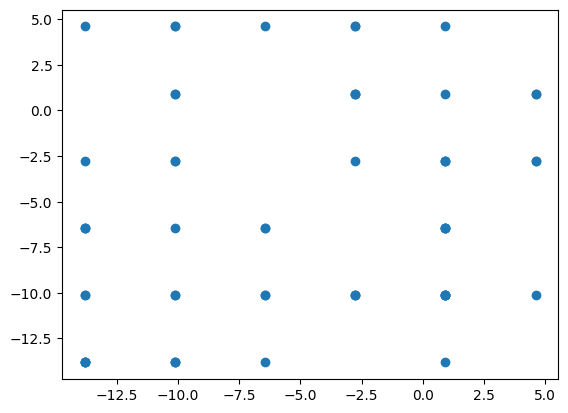

In [59]:
plt.scatter(np.log(sorted_filtered_combinations['gamma']), np.log(sorted_filtered_combinations['C']))